<h1> Deep Learning Model 3

First score is Private and second score is Public score

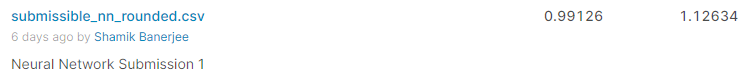

#### Imports

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import activations
from IPython.display import clear_output as cclear

from tensorflow.keras import backend as K 
from tensorflow.keras.callbacks import ModelCheckpoint

#### Functions

In [ ]:
# Call back to terminate at certain train loss

In [ ]:
class terminate_on_acc(tf.keras.callbacks.Callback):    
    def on_epoch_end(self, epoch, logs={}):
        loss = logs['loss']
        if loss < target_loss:
            self.model.stop_training = True
terminate_on_acc = terminate_on_acc()

n_steps_in, n_steps_out = 1885, 28              # input is 1885 days, output 28 days
n_features = 1

In [2]:
# Training function.

# In this training strategy we dont go by store_by_store, we decided to split products into departments instead as 
# same products may behave same across stores, this can be helpful for LSTM models as they depend on patterns.

# However, entire data was used to do the training both for eval and val csv. This can be changed to try a different
# approach where we use only 1 or 2 yr data as LSTMs are not good at remembering long sequences.

# Our data split is like this: 
# our model is created to take 1885 days input and 28 days output
# for eval csv we use 28 to 1913 as xtrain and 1913 to 1941 as ytain, then we predict on 56 to 1941
# for val csv we use 0 to 1885 as xtrain and 1885 to 1913 as ytain, then we predict on 28 to 1913

# so both the times we are predicting 28 days and it is 1941 to 1969 for eval and 1913 to 1941 for val.

# df - can be sales_train_ev or sales_train_validation
# dept_id - can be any of the 7 dept products belong to as ['HOBBIES_1', 'HOBBIES_2', 'FOODS_1','FOODS_2','FOODS_3',
#                                                          'HOUSEHOLD_1','HOUSEHOLD_2', ]
# epoch_no - we keep changing it because different dept requires different model, different target_loss and different epoch no
# model - we might use different models for different departments

In [1]:
def train_NN(df, dept_id, epoch_no, model):    
    
    dept_df = df[df.dept_id == dept_id]
    print('Working on Dept ', dept_id, 'Total rows to process ', len(dept_df))
    
    id_col = list(dept_df['id'])                                     # we preserve the id_col to recreate the output later
    dept_df = dept_df.drop(['id','item_id','dept_id','cat_id','store_id','state_id'], 1)

    
    if df.id.iloc[0].find('evaluation') != -1:                       # if evaluation data
        xtr_from, xtr_to, ytr_to = 28, 1913, 1941                    # train from 28 to 1913 predict 1913 to 1941
        xte_from, xte_to = 56, 1941                                  # validate from 28 to 1941 predict 1941 to 1969
        checkpoint = ModelCheckpoint(filepath='model_'+str(dept_id)+'_ev.h5',\ 
                                     monitor='loss', verbose=1, save_best_only=True, mode='auto')
    if df.id.iloc[0].find('validation') != -1:                       # if validation data
        xtr_from, xtr_to, ytr_to = 0, 1913-28, 1913                  # train from 0 to 1913-28 predict 1913-28 to 1913
        xte_from, xte_to = 28, 1913                                  # validate from 28 to 1913 predict 1913 to 1941
        checkpoint = ModelCheckpoint(filepath='model_'+str(dept_id)+'_val.h5',\ 
                                     monitor='loss', verbose=1, save_best_only=True, mode='auto')
    
    
    X_train, y_train = dept_df.iloc[:, xtr_from:xtr_to], dept_df.iloc[:, xtr_to:ytr_to]
    X_test = dept_df.iloc[:, xte_from:xte_to]    
    
    X_train, y_train = tf.convert_to_tensor(X_train), tf.convert_to_tensor(y_train)
    X_test = tf.convert_to_tensor(X_test)
    
    X_train = tf.reshape(X_train, shape = (X_train.shape[0], X_train.shape[1], n_features))
    y_train = tf.reshape(y_train, shape = (y_train.shape[0], y_train.shape[1], n_features))
    X_test = tf.reshape(X_train, shape = (X_train.shape[0], X_train.shape[1], n_features))
    
    
    
    model.fit(X_train, y_train, epochs=epoch_no, verbose=1, callbacks = [terminate_on_acc, checkpoint])
    
    print('Predicting...')
    y_hat = model.predict(X_test)
    
    out_df = pd.DataFrame(y_hat)
    l = []                                              # In this part we rename the columns to F_1, F_2 ....
    for i in range(1,29):
        l.append('F'+str(i))
    out_df.columns = l
    out_df['id'] = id_col
    
    cols = list(out_df)                                           
    cols = [cols[-1]] + cols[:-1]
    out_df = out_df[cols]
    
    print('Writing output...')
    print('Done.')
    return out_df

#### Predicting for Evaluation Data

In [7]:
df = pd.read_csv('sales_train_evaluation.csv')
dept_list = list(set(df.dept_id))
dept_list

['HOUSEHOLD_1',
 'FOODS_3',
 'FOODS_2',
 'HOUSEHOLD_2',
 'HOBBIES_2',
 'FOODS_1',
 'HOBBIES_1']

In [4]:
target_loss = 4    

model = Sequential()        
model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(2, activation='relu'))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

dept_name_to_train = 'HOBBIES_1'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_ev.csv', index=False)

In [4]:
target_loss = 4    

model = Sequential()        
model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(2, activation='relu'))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

dept_name_to_train = 'HOBBIES_2'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_ev.csv', index=False)

Working on Dept  HOBBIES_2 Total rows to process  1490
Epoch 1/10
47/47 [==============================] - ETA: 0s - loss: 0.8342
Epoch 00001: loss improved from inf to 0.83422, saving model to model_HOBBIES_2.h5
47/47 [==============================] - 54s 1s/step - loss: 0.8342
Predicting...
Writing output...
Done.


In [7]:
target_loss = 7.2421         

model = Sequential()        
model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(2, activation='relu'))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

dept_name_to_train = 'HOUSEHOLD_1'

out_df = train_NN(df, dept_name_to_train, 25, model)
out_df.to_csv(str(dept_name_to_train)+'_ev.csv', index=False)

Working on Dept  HOUSEHOLD_1 Total rows to process  5320
Epoch 1/25
167/167 [==============================] - ETA: 0s - loss: 8.0297
Epoch 00001: loss improved from inf to 8.02974, saving model to model_HOUSEHOLD_1.h5
167/167 [==============================] - 193s 1s/step - loss: 8.0297
Epoch 2/25
167/167 [==============================] - ETA: 0s - loss: 7.2415
Epoch 00002: loss improved from 8.02974 to 7.24148, saving model to model_HOUSEHOLD_1.h5
167/167 [==============================] - 191s 1s/step - loss: 7.2415
Predicting...
Writing output...
Done.


In [9]:
model = Sequential()        
model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(2, activation='relu'))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

target_loss = 4      
dept_name_to_train = 'HOUSEHOLD_2'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_ev.csv', index=False)

Working on Dept  HOUSEHOLD_2 Total rows to process  5150
Epoch 1/10
161/161 [==============================] - ETA: 0s - loss: 0.9070
Epoch 00001: loss improved from inf to 0.90705, saving model to model_HOUSEHOLD_2.h5
161/161 [==============================] - 186s 1s/step - loss: 0.9070
Predicting...
Writing output...
Done.


In [12]:
model = Sequential()        
model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(2, activation='relu'))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

target_val_loss = 7

dept_name_to_train = 'FOODS_1'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_ev.csv', index=False)

Working on Dept  FOODS_1 Total rows to process  2160
Epoch 1/10
68/68 [==============================] - ETA: 0s - loss: 14.0377
Epoch 00001: loss improved from inf to 14.03774, saving model to model_FOODS_1.h5
68/68 [==============================] - 79s 1s/step - loss: 14.0377
Epoch 2/10
68/68 [==============================] - ETA: 0s - loss: 10.3746
Epoch 00002: loss improved from 14.03774 to 10.37458, saving model to model_FOODS_1.h5
68/68 [==============================] - 78s 1s/step - loss: 10.3746
Epoch 3/10
68/68 [==============================] - ETA: 0s - loss: 8.5670
Epoch 00003: loss improved from 10.37458 to 8.56698, saving model to model_FOODS_1.h5
68/68 [==============================] - 78s 1s/step - loss: 8.5670
Epoch 4/10
68/68 [==============================] - ETA: 0s - loss: 8.0746
Epoch 00004: loss improved from 8.56698 to 8.07459, saving model to model_FOODS_1.h5
68/68 [==============================] - 78s 1s/step - loss: 8.0746
Epoch 5/10
68/68 [=============

In [6]:
target_loss = 5

model = Sequential()        
model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(2, activation='relu'))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

dept_name_to_train = 'FOODS_2'

out_df = train_NN(df, dept_name_to_train, 5, model)
out_df.to_csv(str(dept_name_to_train)+'_ev.csv', index=False)

Working on Dept  FOODS_2 Total rows to process  3980
Epoch 1/5
125/125 [==============================] - ETA: 0s - loss: 8.2226
Epoch 00001: loss improved from inf to 8.22258, saving model to model_FOODS_2.h5
125/125 [==============================] - 144s 1s/step - loss: 8.2226
Epoch 2/5
125/125 [==============================] - ETA: 0s - loss: 5.7017
Epoch 00002: loss improved from 8.22258 to 5.70167, saving model to model_FOODS_2.h5
125/125 [==============================] - 145s 1s/step - loss: 5.7017
Epoch 3/5
125/125 [==============================] - ETA: 0s - loss: 4.8907
Epoch 00003: loss improved from 5.70167 to 4.89071, saving model to model_FOODS_2.h5
125/125 [==============================] - 145s 1s/step - loss: 4.8907
Predicting...
Writing output...
Done.


In [10]:
target_loss = 10

model = Sequential()        
model.add(LSTM(5, activation='relu', input_shape=(n_steps_in, n_features)))
# model.add(LSTM(5, activation='relu'))
model.add(Dense(200))
model.add(Dense(150))
model.add(Dense(150))
model.add(Dense(50))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

dept_name_to_train = 'FOODS_3'

out_df = train_NN(df, dept_name_to_train, 50, model)
out_df.to_csv(str(dept_name_to_train)+'_ev.csv', index=False)

Working on Dept  FOODS_3 Total rows to process  8230
Epoch 1/50
258/258 [==============================] - ETA: 0s - loss: 26.6128
Epoch 00001: loss improved from inf to 26.61278, saving model to model_FOODS_3_ev.h5
258/258 [==============================] - 129s 498ms/step - loss: 26.6128
Epoch 2/50
258/258 [==============================] - ETA: 0s - loss: 19.0260
Epoch 00002: loss improved from 26.61278 to 19.02600, saving model to model_FOODS_3_ev.h5
258/258 [==============================] - 123s 478ms/step - loss: 19.0260
Epoch 3/50
258/258 [==============================] - ETA: 0s - loss: 15.6178
Epoch 00003: loss improved from 19.02600 to 15.61780, saving model to model_FOODS_3_ev.h5
258/258 [==============================] - 123s 478ms/step - loss: 15.6178
Epoch 4/50
258/258 [==============================] - ETA: 0s - loss: 13.0556
Epoch 00004: loss improved from 15.61780 to 13.05558, saving model to model_FOODS_3_ev.h5
258/258 [==============================] - 123s 478ms/s

#### Training for Validation Data

In [2]:
df = pd.read_csv('sales_train_validation.csv')
dept_list = list(set(df.dept_id))
dept_list

['HOUSEHOLD_1',
 'FOODS_3',
 'FOODS_2',
 'HOUSEHOLD_2',
 'HOBBIES_2',
 'FOODS_1',
 'HOBBIES_1']

In [4]:
target_loss = 4    

model = Sequential()        
model.add(LSTM(15, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(2, activation='relu'))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

dept_name_to_train = 'HOBBIES_1'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_val.csv', index=False)

Working on Dept  HOBBIES_1 Total rows to process  4160
Epoch 1/10
130/130 [==============================] - ETA: 0s - loss: 943.8334
Epoch 00001: loss improved from inf to 943.83337, saving model to model_HOBBIES_1_val.h5
130/130 [==============================] - 129s 993ms/step - loss: 943.8334
Epoch 2/10
130/130 [==============================] - ETA: 0s - loss: 5.7984
Epoch 00002: loss improved from 943.83337 to 5.79838, saving model to model_HOBBIES_1_val.h5
130/130 [==============================] - 131s 1s/step - loss: 5.7984
Epoch 3/10
130/130 [==============================] - ETA: 0s - loss: 5.3707
Epoch 00003: loss improved from 5.79838 to 5.37069, saving model to model_HOBBIES_1_val.h5
130/130 [==============================] - 132s 1s/step - loss: 5.3707
Epoch 4/10
130/130 [==============================] - ETA: 0s - loss: 5.2914
Epoch 00004: loss improved from 5.37069 to 5.29143, saving model to model_HOBBIES_1_val.h5
130/130 [==============================] - 133s 1s/st

In [5]:
target_loss = 4    

model = Sequential()        
model.add(LSTM(4, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(2, activation='relu'))
# model.add(Dense(50))
# model.add(Dense(10))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

dept_name_to_train = 'HOBBIES_2'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_val.csv', index=False)

Working on Dept  HOBBIES_2 Total rows to process  1490
Epoch 1/10
47/47 [==============================] - ETA: 0s - loss: 0.6868
Epoch 00001: loss improved from inf to 0.68676, saving model to model_HOBBIES_2_val.h5
47/47 [==============================] - 52s 1s/step - loss: 0.6868
Predicting...
Writing output...
Done.


In [3]:
target_loss = 7.85         

model = Sequential()        
model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(2, activation='relu'))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

dept_name_to_train = 'HOUSEHOLD_1'

out_df = train_NN(df, dept_name_to_train, 25, model)
out_df.to_csv(str(dept_name_to_train)+'_val.csv', index=False)

Working on Dept  HOUSEHOLD_1 Total rows to process  5320
Epoch 1/25
167/167 [==============================] - ETA: 0s - loss: 10.1908
Epoch 00001: loss improved from inf to 10.19076, saving model to model_HOUSEHOLD_1_val.h5
167/167 [==============================] - 188s 1s/step - loss: 10.1908
Epoch 2/25
167/167 [==============================] - ETA: 0s - loss: 7.6923
Epoch 00002: loss improved from 10.19076 to 7.69227, saving model to model_HOUSEHOLD_1_val.h5
167/167 [==============================] - 210s 1s/step - loss: 7.6923
Predicting...
Writing output...
Done.


In [4]:
target_loss = 4  

model = Sequential()        
model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(2, activation='relu'))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
    
dept_name_to_train = 'HOUSEHOLD_2'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_val.csv', index=False)

Working on Dept  HOUSEHOLD_2 Total rows to process  5150
Epoch 1/10
161/161 [==============================] - ETA: 0s - loss: 0.9760
Epoch 00001: loss improved from inf to 0.97595, saving model to model_HOUSEHOLD_2_val.h5
161/161 [==============================] - 176s 1s/step - loss: 0.9760
Predicting...
Writing output...
Done.


In [4]:
target_loss = 7

model = Sequential()        
model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(2, activation='relu'))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

dept_name_to_train = 'FOODS_1'

out_df = train_NN(df, dept_name_to_train, 10, model)
out_df.to_csv(str(dept_name_to_train)+'_val.csv', index=False)

Working on Dept  FOODS_1 Total rows to process  2160
Epoch 1/10
68/68 [==============================] - ETA: 0s - loss: 10.0527
Epoch 00001: loss improved from inf to 10.05268, saving model to model_FOODS_1_val.h5
68/68 [==============================] - 78s 1s/step - loss: 10.0527
Epoch 2/10
68/68 [==============================] - ETA: 0s - loss: 9.0912
Epoch 00002: loss improved from 10.05268 to 9.09118, saving model to model_FOODS_1_val.h5
68/68 [==============================] - 77s 1s/step - loss: 9.0912
Epoch 3/10
68/68 [==============================] - ETA: 0s - loss: 8.6219
Epoch 00003: loss improved from 9.09118 to 8.62195, saving model to model_FOODS_1_val.h5
68/68 [==============================] - 78s 1s/step - loss: 8.6219
Epoch 4/10
68/68 [==============================] - ETA: 0s - loss: 24.8518
Epoch 00004: loss did not improve from 8.62195
68/68 [==============================] - 78s 1s/step - loss: 24.8518
Epoch 5/10
68/68 [==============================] - ETA: 0s

In [3]:
target_loss = 5

model = Sequential()        
model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(2, activation='relu'))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

dept_name_to_train = 'FOODS_2'

out_df = train_NN(df, dept_name_to_train, 5, model)
out_df.to_csv(str(dept_name_to_train)+'_val.csv', index=False)

Working on Dept  FOODS_2 Total rows to process  3980
Epoch 1/5
125/125 [==============================] - ETA: 0s - loss: 10.1698
Epoch 00001: loss improved from inf to 10.16980, saving model to model_FOODS_2_val.h5
125/125 [==============================] - 145s 1s/step - loss: 10.1698
Epoch 2/5
125/125 [==============================] - ETA: 0s - loss: 8.6213
Epoch 00002: loss improved from 10.16980 to 8.62132, saving model to model_FOODS_2_val.h5
125/125 [==============================] - 142s 1s/step - loss: 8.6213
Epoch 3/5
125/125 [==============================] - ETA: 0s - loss: 8.1953
Epoch 00003: loss improved from 8.62132 to 8.19530, saving model to model_FOODS_2_val.h5
125/125 [==============================] - 142s 1s/step - loss: 8.1953
Epoch 4/5
125/125 [==============================] - ETA: 0s - loss: 7.9333
Epoch 00004: loss improved from 8.19530 to 7.93329, saving model to model_FOODS_2_val.h5
125/125 [==============================] - 142s 1s/step - loss: 7.9333
Epo

In [6]:
target_loss = 14

model = Sequential()        
model.add(LSTM(5, activation='relu', input_shape=(n_steps_in, n_features)))
# model.add(LSTM(5, activation='relu'))
model.add(Dense(200))
model.add(Dense(150))
model.add(Dense(150))
model.add(Dense(50))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

dept_name_to_train = 'FOODS_3'

out_df = train_NN(df, dept_name_to_train, 50, model)
out_df.to_csv(str(dept_name_to_train)+'_val.csv', index=False)

Working on Dept  FOODS_3 Total rows to process  8230
Epoch 1/50
258/258 [==============================] - ETA: 0s - loss: 50.1227
Epoch 00001: loss improved from inf to 50.12270, saving model to model_FOODS_3_val.h5
258/258 [==============================] - 126s 488ms/step - loss: 50.1227
Epoch 2/50
258/258 [==============================] - ETA: 0s - loss: 10.5447
Epoch 00002: loss improved from 50.12270 to 10.54469, saving model to model_FOODS_3_val.h5
258/258 [==============================] - 123s 478ms/step - loss: 10.5447
Predicting...
Writing output...
Done.


#### Merging outputs for all departments

In [25]:
def fun(name):
    return pd.read_csv(name+'.csv')

food1ev, food2ev, food3ev = fun('FOODS_1_ev'), fun('FOODS_2_ev'), fun('FOODS_3_ev')
hobbies1ev, hobbies2ev = fun('HOBBIES_1_ev'), fun('HOBBIES_2_ev')
house1ev, house2ev = fun('HOUSEHOLD_1_ev'), fun('HOUSEHOLD_2_ev')

food1val, food2val, food3val = fun('FOODS_1_val'), fun('FOODS_2_val'), fun('FOODS_3_val')
hobbies1val, hobbies2val = fun('HOBBIES_1_val'), fun('HOBBIES_2_val')
house1val, house2val = fun('HOUSEHOLD_1_val'), fun('HOUSEHOLD_2_val')

In [26]:
main_out_df_ev = pd.concat([food1ev, food2ev, food3ev, hobbies1ev, hobbies2ev, house1ev, house2ev], 
                           ignore_index=False)
main_out_df_val = pd.concat([food1val, food2val, food3val, hobbies1val, hobbies2val, house1val, house2val],
                            ignore_index=False)

In [27]:
def reorder(df, main_out):
    df['sp_index'] = (df.index)
    index_dict = dict(zip(df.id, df.sp_index))
    df = df.drop('sp_index', axis=1)
    main_out['sp_index'] = main_out["id"].map(index_dict)
    main_out = main_out.sort_values(by='sp_index', axis=0)
    main_out = main_out.drop('sp_index', axis=1)
    return main_out

In [28]:
out_1 = reorder(pd.read_csv('sales_train_evaluation.csv'), main_out_df_ev)
out_2 = reorder(pd.read_csv('sales_train_validation.csv'), main_out_df_val)

In [29]:
df = pd.concat([out_1, out_2], ignore_index=False)
df.to_csv('submissible_nn.csv')

In [33]:
df = df.round(2)
df.to_csv('submissible_nn.csv')